Это черновик распознавания циферок. Тут довольно страшный код :(  

На то он и исследовательскний :)

In [893]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout

from PIL import ImageEnhance
import json
import scipy.misc

import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from PIL import Image
import skimage
import cv2

from PIL import Image, ImageOps
from scipy import ndimage, misc
import os
import random
import string
from keras.models import model_from_json
import pandas as pd
import keras2onnx
import onnxruntime

from skimage import color,io


Перевод модели в формат ONNX

https://github.com/onnx/keras-onnx

In [894]:
model = model_from_json(open("mnist_mega_model_4_sep_1_7.json").read())
model.load_weights('best_great_model_sep_1_7.hdf5')

In [895]:
onnx_model = keras2onnx.convert_keras(model, model.name)
temp_model_file = 'mnist_mega_model_2.onnx'
keras2onnx.save_model(onnx_model, temp_model_file)
sess = onnxruntime.InferenceSession(temp_model_file)

tf executing eager_mode: True
The ONNX operator number change on the optimization: 70 -> 35


In [897]:
sample_digit = Image.open("our_sample_digits/0_0FJSN.png").resize((28, 28), Image.ANTIALIAS)
sample_digit

In [898]:

sample_digit = Image.open("sample_images/2020-05-15_00-25-13.png").resize((28, 28), Image.ANTIALIAS)
sample_digit

In [899]:

sample_digit = Image.open("sample_images/2020-05-14_22-54-55.png").resize((28, 28), Image.ANTIALIAS)
sample_digit

In [900]:
digit_array = np.array(sample_digit)

In [901]:
digit_array[0][0]=0
digit_array[-1][-1]=255

In [902]:
np.min(digit_array)

0

In [903]:
np.max(digit_array)

255

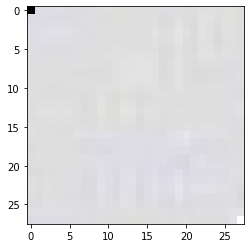

In [904]:
plt.imshow(digit_array, "gray")

In [905]:
if digit_array.shape != (28, 28):
    digit_array = np.max(digit_array, axis=2)

In [906]:
digit_array.shape

(28, 28)

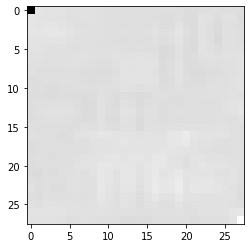

In [907]:
plt.imshow(digit_array, "gray")

Предсказание цифры

In [908]:
model.predict(digit_array.reshape(1, 28, 28, 1)).argmax()

10

То же самое, только с помощью ONNX

In [909]:
data = digit_array.reshape(1, 1, 28, 28, 1).astype(np.float32)
input_names = sess.get_inputs()
feed = zip(sorted(i_.name for i_ in input_names), data)

actual = sess.run(None, dict(feed))


In [910]:
actual[0][0].argmax()

10

Проверим на трейне и тесте как дела с пустыми квадратиками

In [911]:
zero_boxes_to_add = []

for filename in os.listdir("zero_and_marks/zero_boxes/test"):
    if ".jpg" in filename or ".png" in filename:
        filepath = "zero_and_marks/zero_boxes/test/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.max(im, axis=2)
        zero_boxes_to_add.append(im)
        

In [912]:
zero_boxes_data=np.array(zero_boxes_to_add)
zero_boxes_data.shape

(1713, 28, 28)

In [914]:
preds = model.predict(zero_boxes_data.reshape(zero_boxes_data.shape[0], 28, 28, 1))
preds.shape

(1713, 12)

In [915]:
preds = np.argmax(preds, axis=1)

In [916]:
np.min(preds)

10

In [917]:
np.max(preds)

10

In [918]:
len(preds[preds!=10])

0

In [919]:
marked_boxes_to_add = []

for filename in os.listdir("zero_and_marks/marked_boxes/train"):
    if ".jpg" in filename or ".png" in filename:
        filepath = "zero_and_marks/marked_boxes/train/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.min(im, axis=2)

        marked_boxes_to_add.append(im)
        

In [920]:
len(marked_boxes_to_add)

1145

In [921]:
marked_boxes_data=np.array(marked_boxes_to_add).reshape(len(marked_boxes_to_add), 28, 28, 1).astype(np.float32)

In [922]:
preds = model.predict(marked_boxes_data)
preds = np.argmax(preds, axis=1)
preds.shape

(1145,)

In [923]:
np.min(preds)

0

In [924]:
np.max(preds)

11

In [925]:
wrong_preds = preds[preds != 11]

In [926]:
len(wrong_preds)

192

In [927]:
preds[preds != 11]

array([ 4,  0, 10,  7,  7, 10,  9,  0,  5,  7, 10,  9,  4, 10, 10,  4, 10,
        7,  9,  9,  9,  8, 10, 10, 10, 10,  9,  4,  7,  8, 10,  9,  6,  9,
        9,  8,  7,  6,  6,  9,  7,  9,  8,  6, 10,  4,  6, 10,  6, 10,  4,
        1,  4,  6,  9,  6,  9, 10,  0,  4,  9,  8,  8,  9,  8,  4,  8,  8,
        7,  7,  4,  9, 10,  9,  7,  9, 10,  8,  7,  9,  4,  9, 10,  4,  9,
        9, 10,  3,  4,  7,  4, 10,  8, 10,  7, 10, 10, 10,  9,  4,  1,  8,
        9,  9, 10, 10, 10, 10,  0, 10,  7,  9,  6,  7,  7,  9,  6,  8, 10,
        4,  4, 10,  9, 10,  9,  4,  4, 10,  9, 10,  4,  7,  1, 10,  0,  7,
        4,  8,  4,  7,  6,  4,  9,  9,  9, 10,  9,  8,  7, 10,  7,  7, 10,
        7,  6,  6,  6,  9,  8,  9,  9,  0,  7, 10,  7,  8,  6,  6,  4,  1,
       10,  8, 10, 10, 10,  7,  0,  6,  7,  6,  8,  9, 10,  9,  9,  4,  4,
       10, 10,  9,  4,  6])

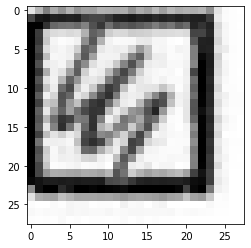

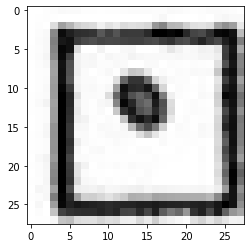

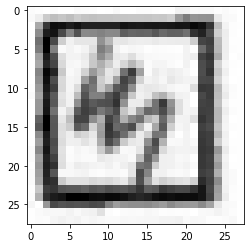

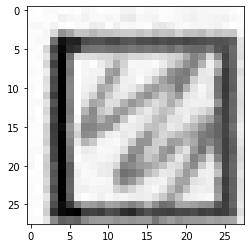

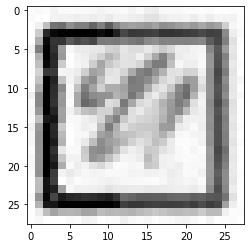

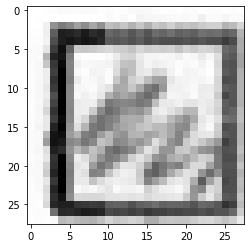

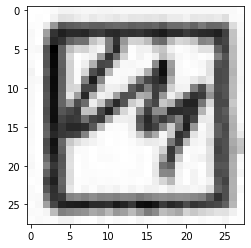

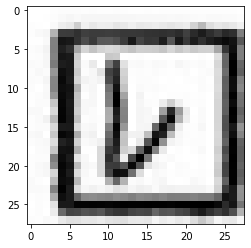

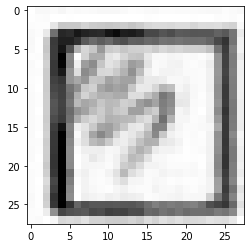

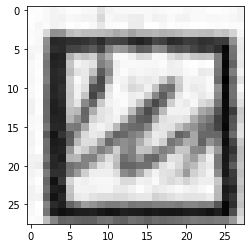

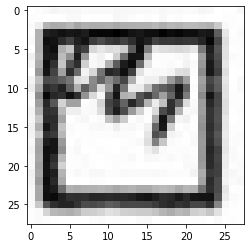

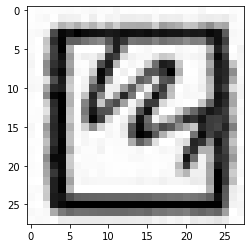

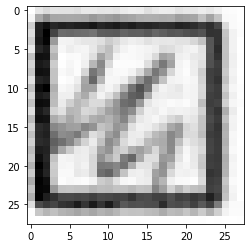

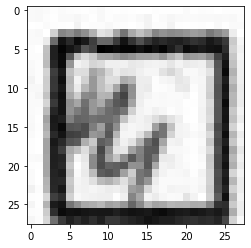

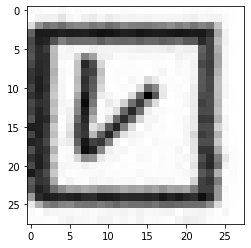

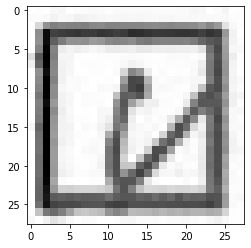

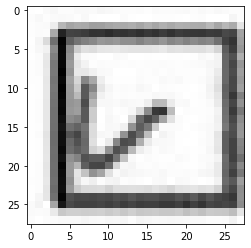

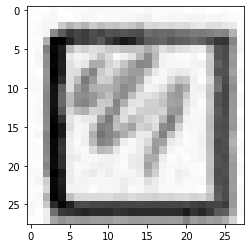

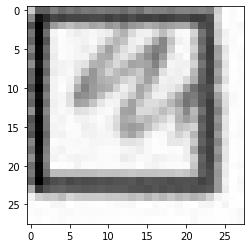

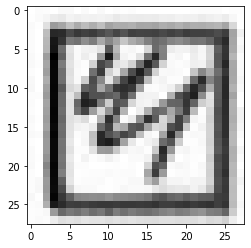

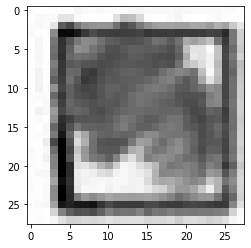

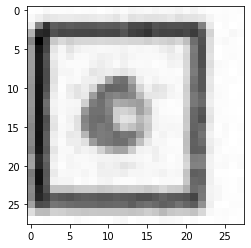

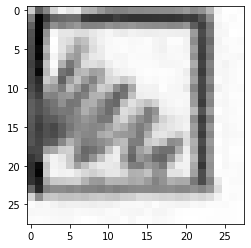

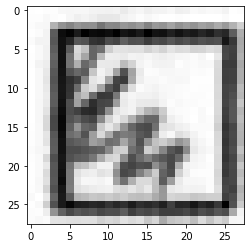

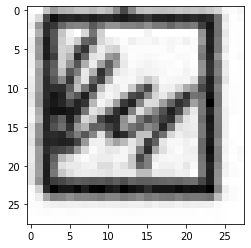

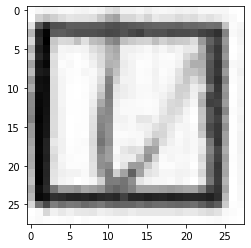

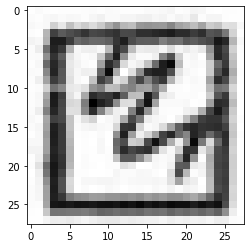

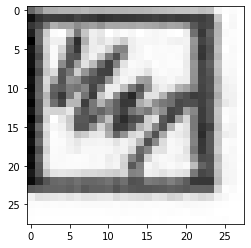

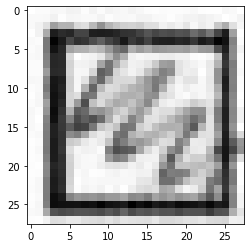

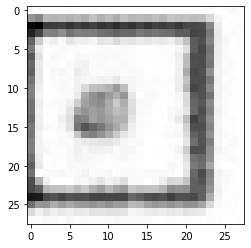

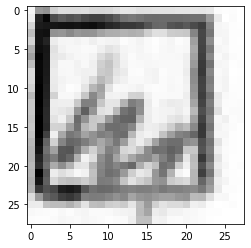

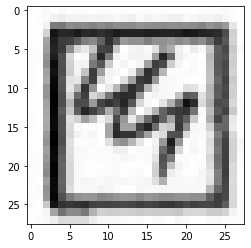

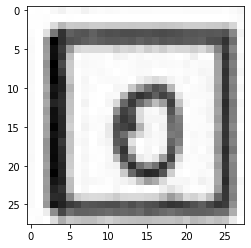

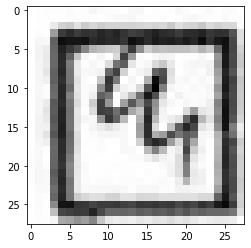

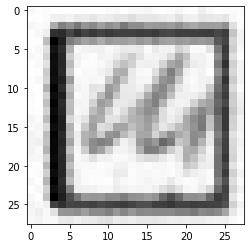

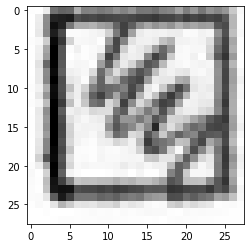

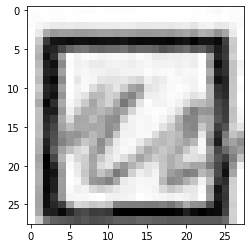

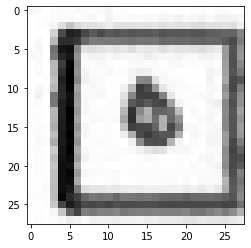

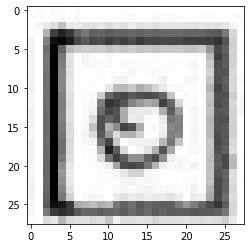

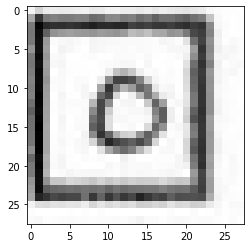

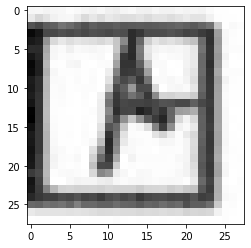

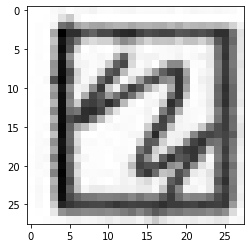

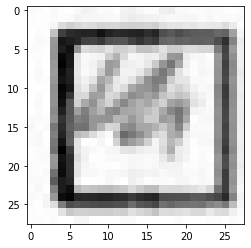

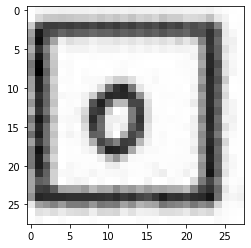

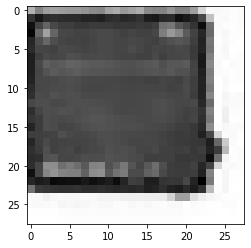

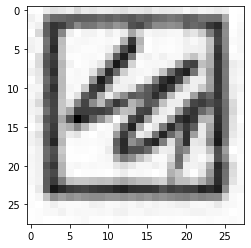

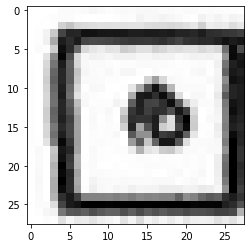

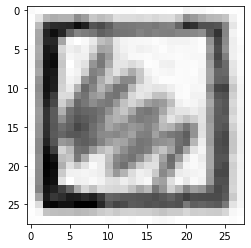

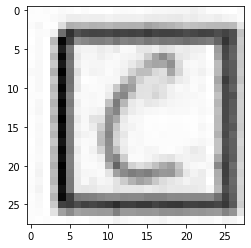

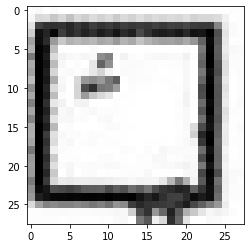

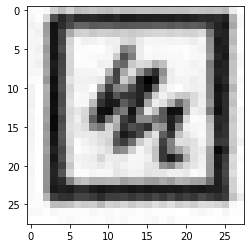

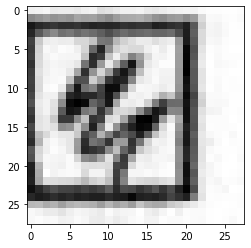

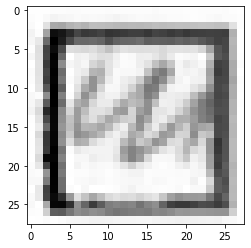

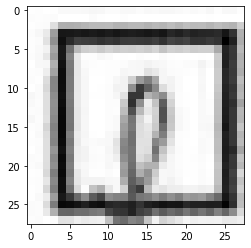

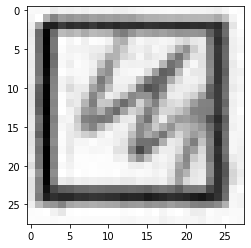

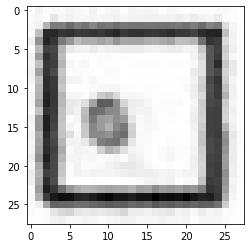

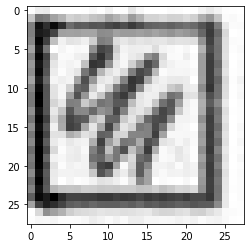

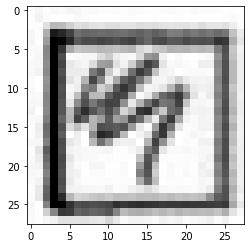

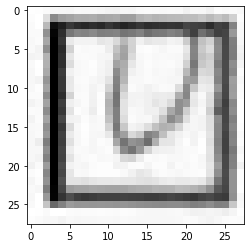

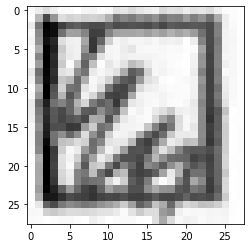

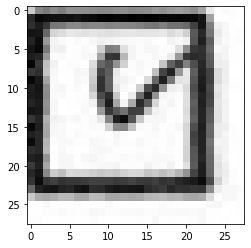

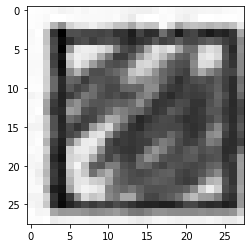

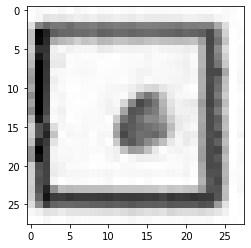

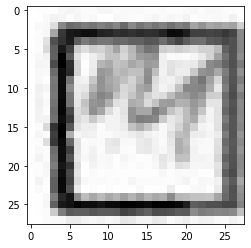

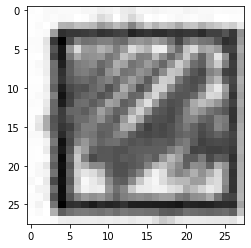

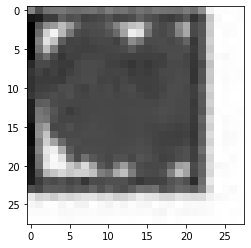

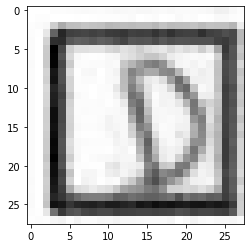

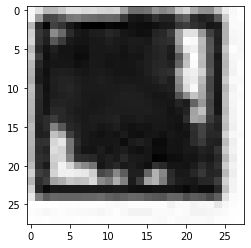

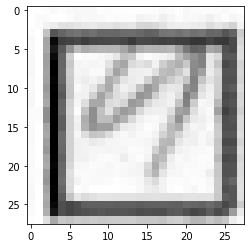

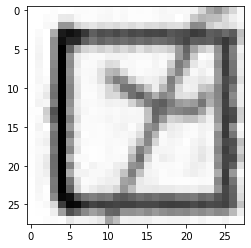

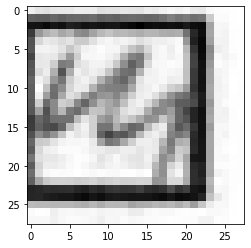

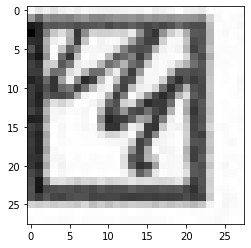

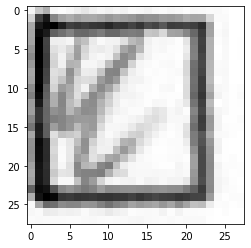

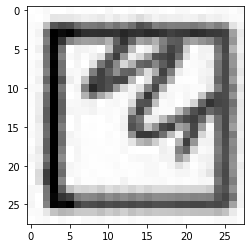

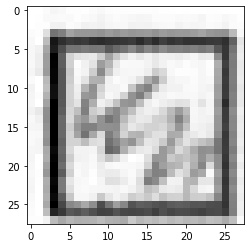

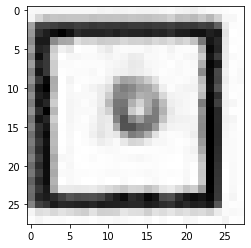

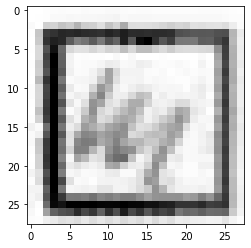

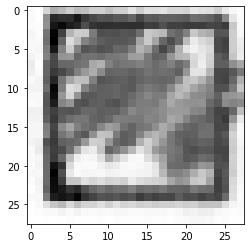

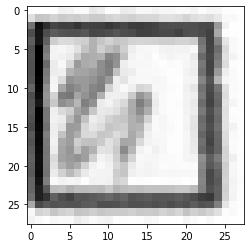

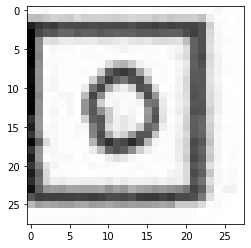

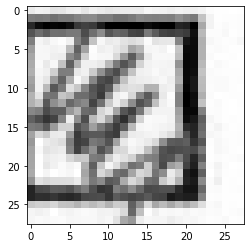

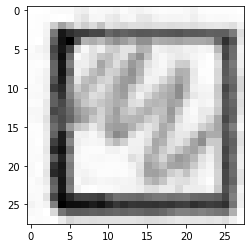

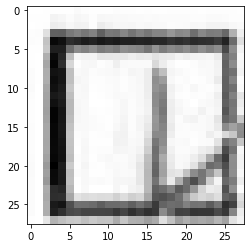

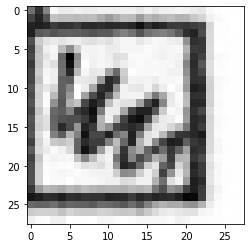

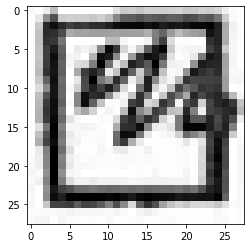

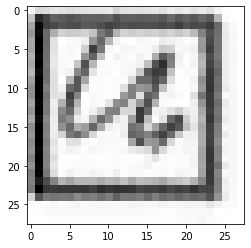

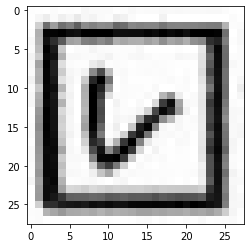

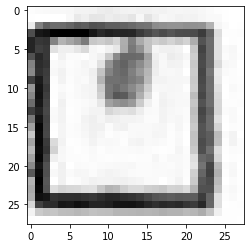

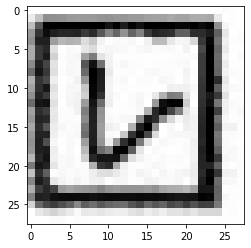

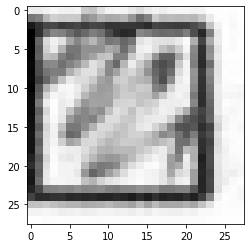

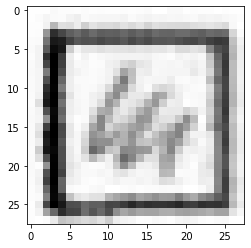

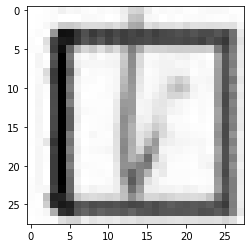

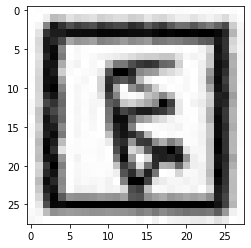

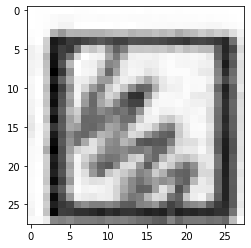

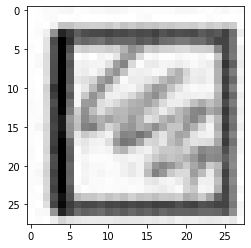

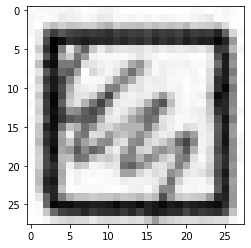

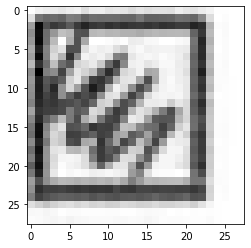

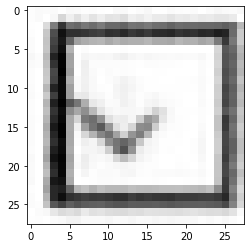

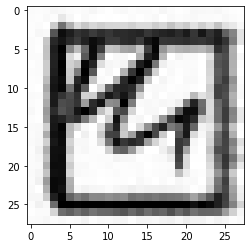

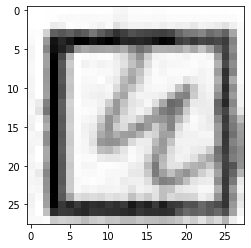

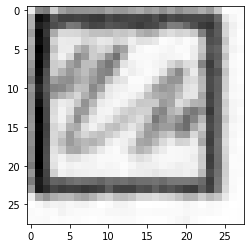

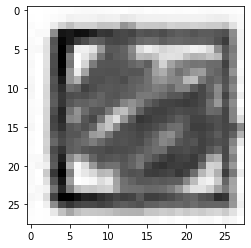

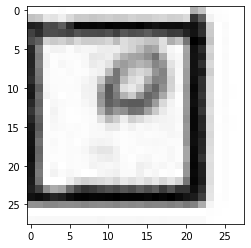

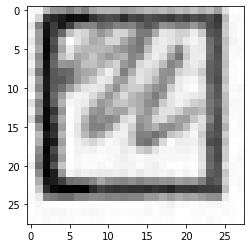

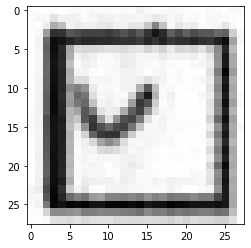

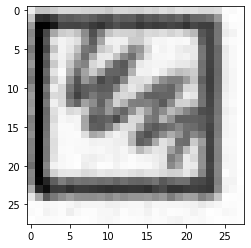

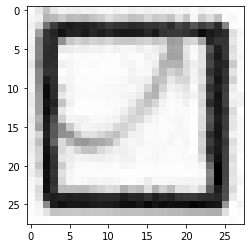

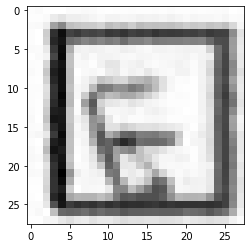

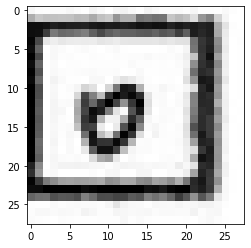

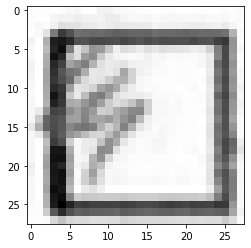

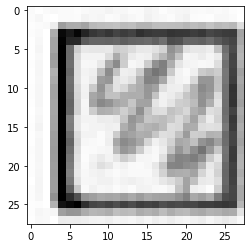

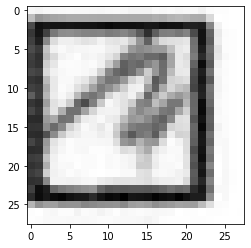

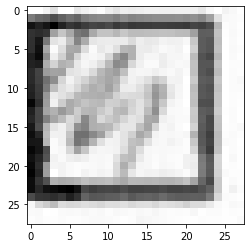

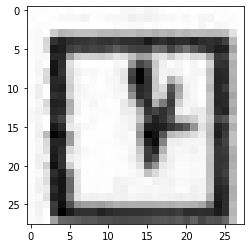

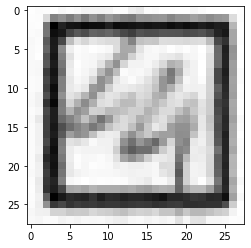

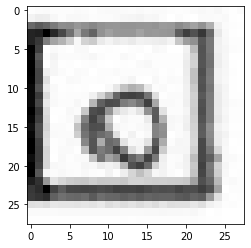

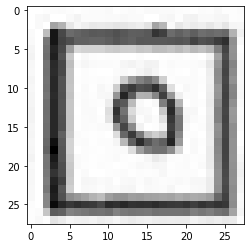

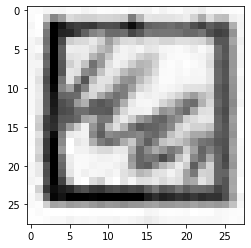

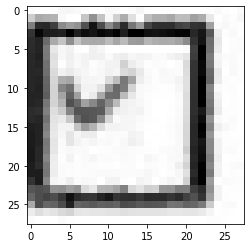

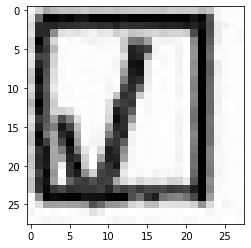

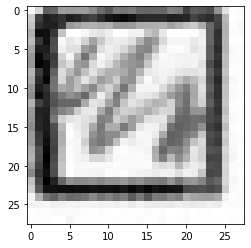

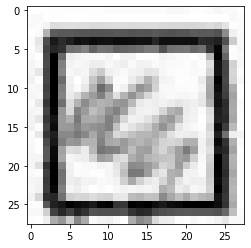

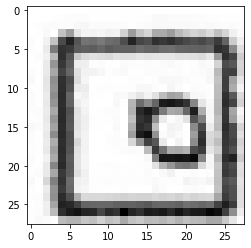

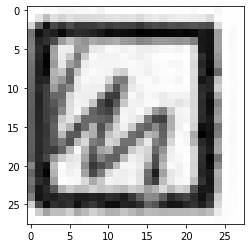

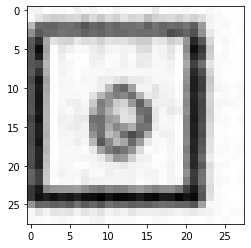

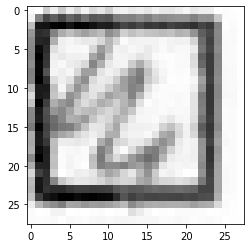

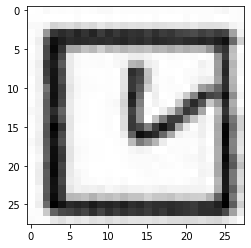

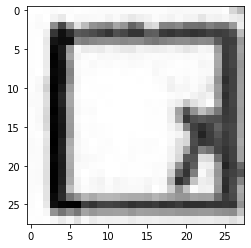

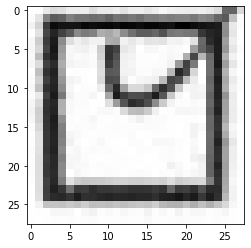

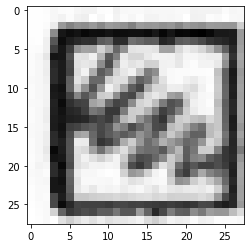

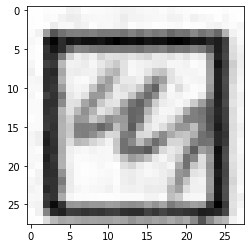

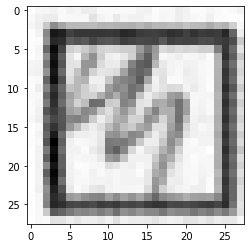

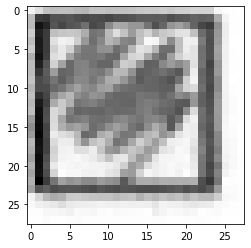

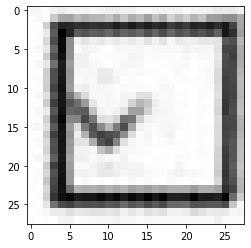

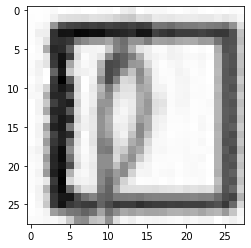

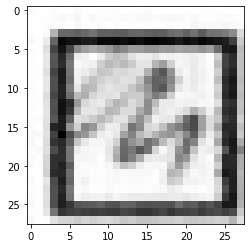

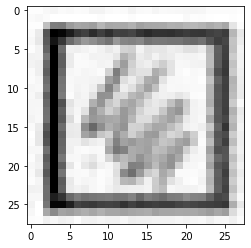

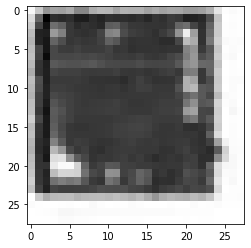

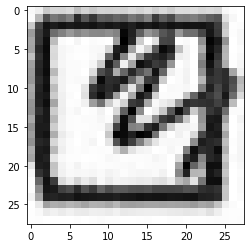

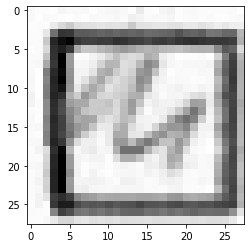

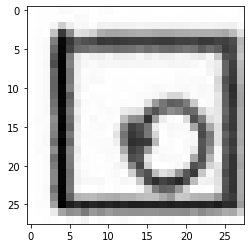

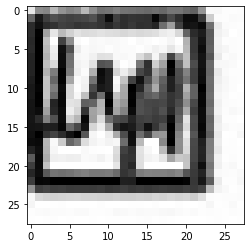

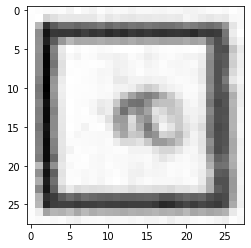

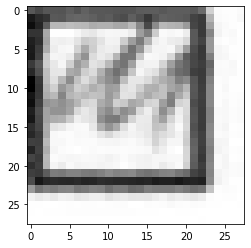

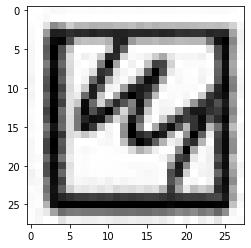

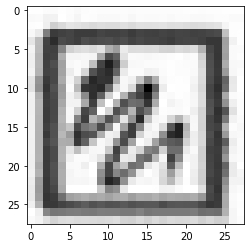

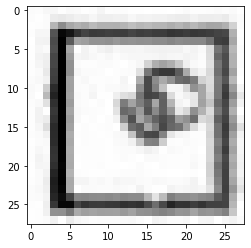

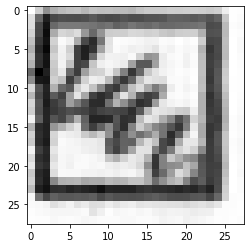

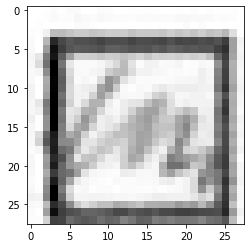

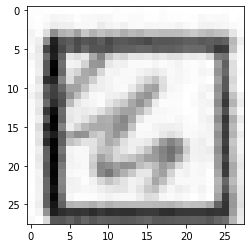

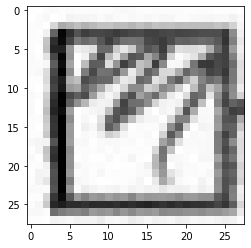

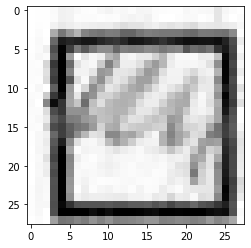

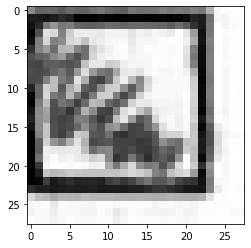

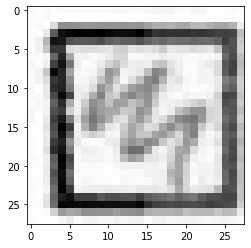

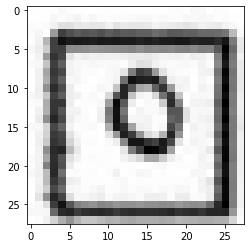

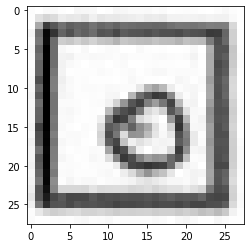

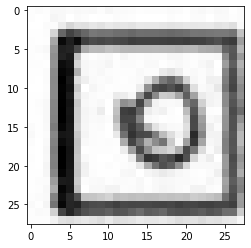

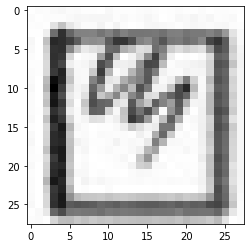

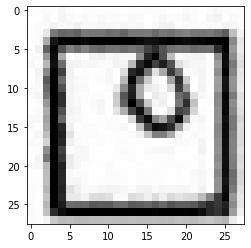

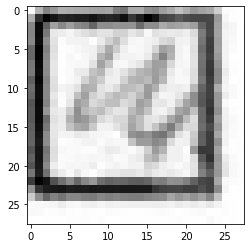

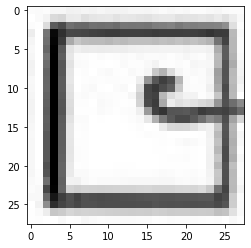

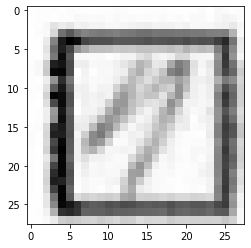

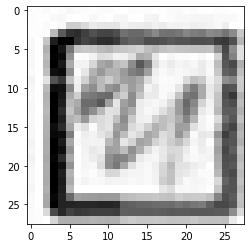

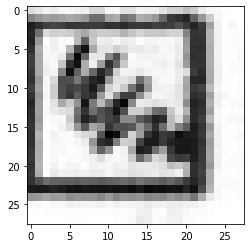

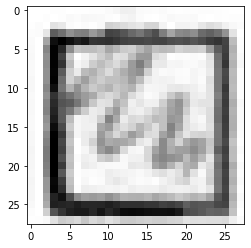

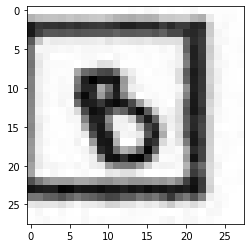

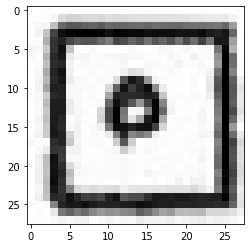

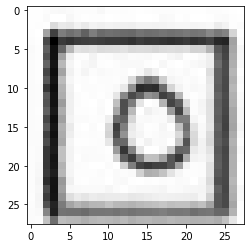

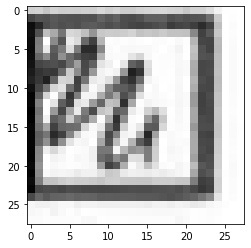

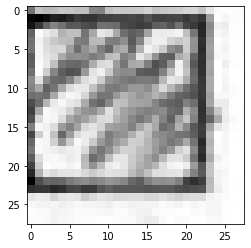

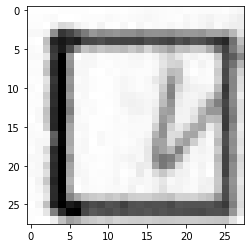

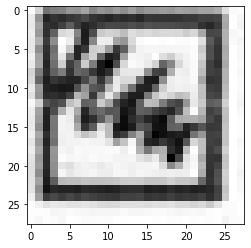

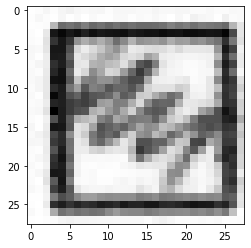

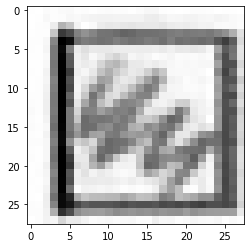

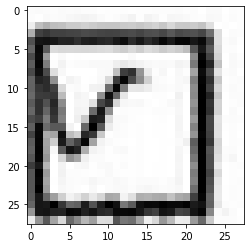

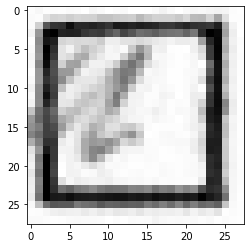

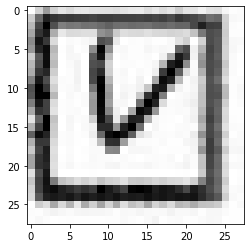

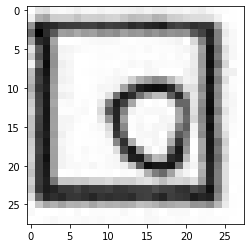

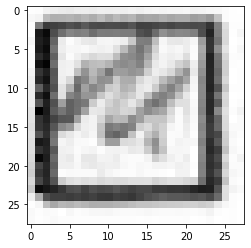

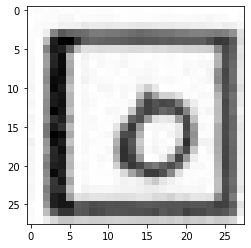

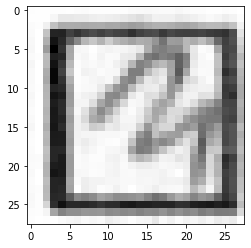

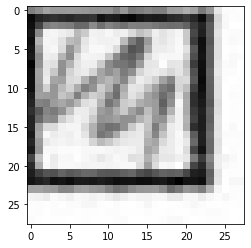

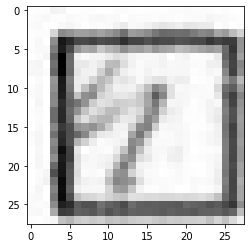

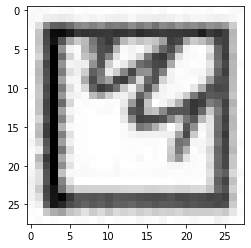

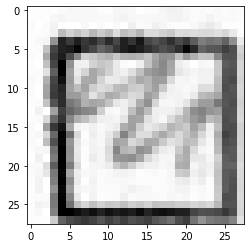

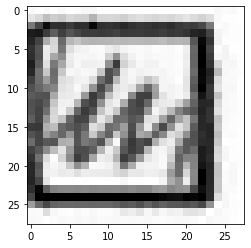

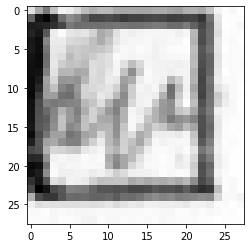

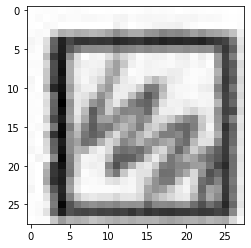

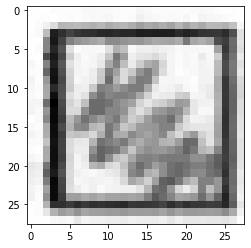

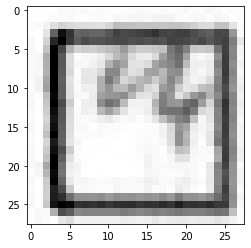

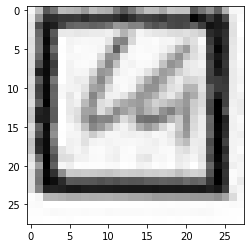

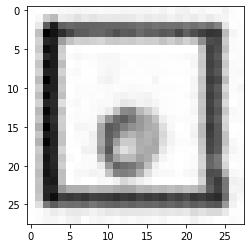

In [928]:
for i in range(len(marked_boxes_data[preds != 11])):
    plt.imshow(marked_boxes_data[preds != 11][i].reshape(28, 28), "gray")
    plt.show()

In [396]:
preds[preds != 11][15]

10

5


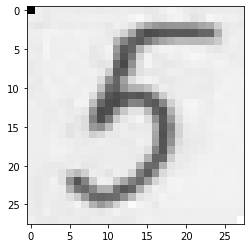

6


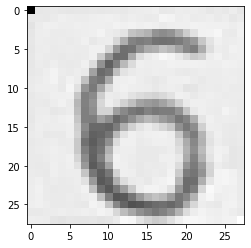

11


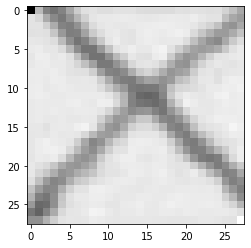

10


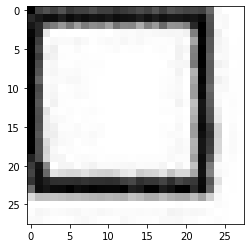

11


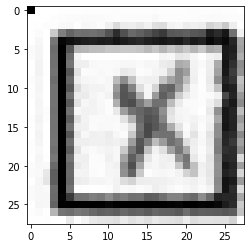

9


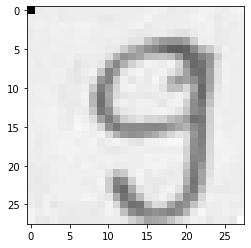

4


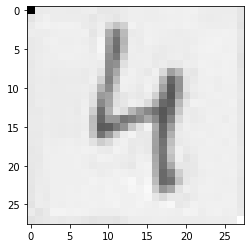

10


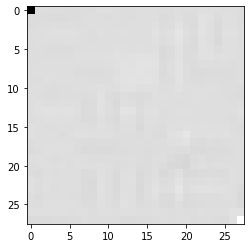

8


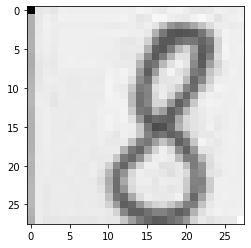

10


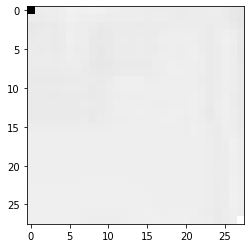

10


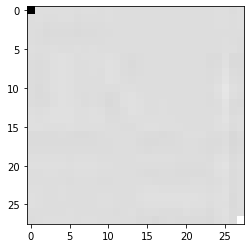

11


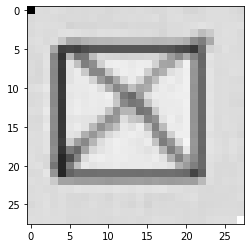

7


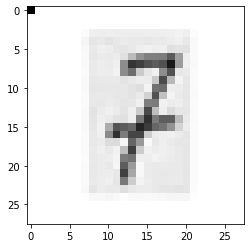

10


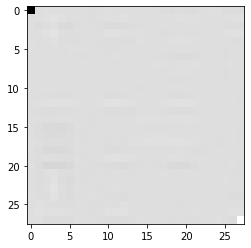

0


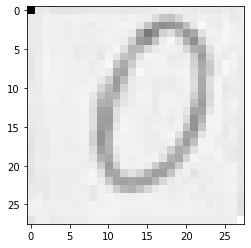

10


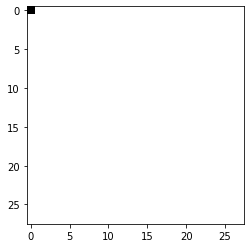

3


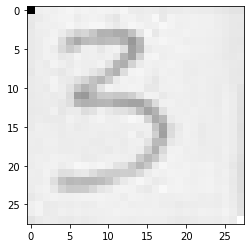

10


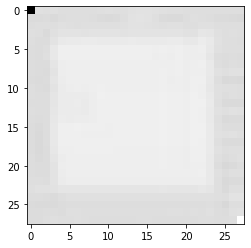

1


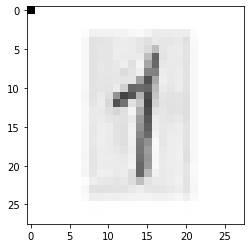

10


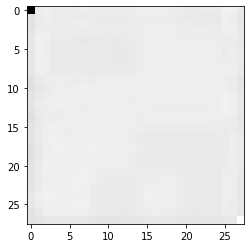

2


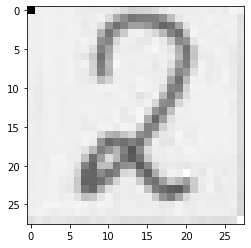

10


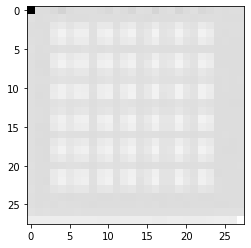

In [929]:
marked_boxes_to_add = []

for filename in os.listdir("sample_images"):
    if ".jpg" in filename or ".png" in filename:
        plt.figure()
        filepath = "sample_images/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        im[0][0] = 0
        im[-1][-1] = 255
        
        if im.shape != (28, 28):
            im = np.min(im, axis=2)
        #im[im > 200] = 255
        preds = model.predict(im.reshape(1, 28, 28, 1))
        print(np.argmax(preds))
        plt.imshow(im, "gray")
        plt.show()
        
        